<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/06a_exo_supp_webscraping.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/06a_exo_supp_webscraping.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/06a_exo_supp_webscraping.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fp
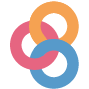

In [1]:
#| echo: false
#| output: 'asis'
#| include: true
#| eval: true

import sys
sys.path.insert(1, '../../../../') #insert the utils module
from utils import print_badges

#print_badges(__file__)
print_badges("content/course/manipulation/06a_exo_supp_webscraping.qmd")

Cette page présente une série d'exercices de webscraping. Ils permettent 
d'aller plus loin que le [chapitre dédié](#webscraping)

## Construction automatisée d'une liste de courses via webscraping :spaghetti: :pizza: :strawberry:

Les comptes sont dans le rouge, le banquier appelle tous les jours.
Plus le choix : fini les commandes de plats tout faits via des plateformes bien connues,
il va falloir se faire des bons petits plats soi-même.
Mais la cuisine à l'ancienne, c'est long : il faut trouver le bon livre de cuisine,
la bonne recette, faire des règles de trois pour calculer les bonnes proportions, etc.
Et après ça, faire une liste de courses...

Heureusement, [Marmiton](https://www.marmiton.org/) est là pour nous.
Dans ce TP, on va construire un outil Python qui permet d'exporter directement une liste de courses,
en fonctions des plats que l'on a envie de manger cette semaine. Et tout ça en *webscrapant* les données de Marmiton. Plus d'excuse !

Pour cet exercice, on va utiliser principalement trois librairies très utilisées en webscraping :

* `requests` & `BeautifulSoup` pour scraper des pages statiques ;
* `selenium` lorsque l'on aura besoin d'interagir avec les éléments scriptés des pages web.

Pour pouvoir utiliser `selenium`, il est nécessaire d'avoir installé le *chromedriver* ([instructions](LIEN A AJOUTER)),
ou bien le driver adapté si vous utilisez un autre navigateur que Google Chrome.

1. Analyser comment fonctionne la recherche d'une recette sur Marmiton (structure de l'URL) et coder un outil
permettant de récupérer (à l'aide de `requests`) le code html des résultats de la recherche pour une recette donnée.
Formatter ce code en un arbre lxml à l'aide de `BeautifulSoup`.


In [2]:
import requests
from bs4 import BeautifulSoup

In [3]:
PLAT = "pates carbonara"
BASE_URL = "https://www.marmiton.org"
URL_SEARCH = BASE_URL + "/recettes/recherche.aspx?aqt=" + PLAT

Vous pouvez vérifier que `python` récupère bien un résultat à l'URL voulu en tapant 


In [4]:
requests.get(URL_SEARCH).status_code

Si le code retour est 200, il y a bien du contenu accessible sur la page. 

{{% box status="note" title="Note" icon="fa fa-comment" %}}
L'utilisation de l'option *"lxml"* avec `BeautifulSoup` nécessite d'avoir
installé avant cela la librairie `lxml`.
{{% /box %}}


In [5]:
response = requests.get(URL_SEARCH).text
soup = BeautifulSoup(response, "lxml")

2. Afficher le code source html de la page des résultats de la recherche à l'aide de votre navigateur (click droit sur la page => Inspecter),
analyser la structure de l'arbre,
et récupérer le code html de chacune des recettes.
A l'aide d'une boucle, récupérer pour chaque recette sa note moyenne et le nombre de fois où elle a été notée.


In [6]:
import re
import numpy as np

In [7]:
found_recipes = soup.find_all(name="a", class_=re.compile("^SearchResultsstyle__SearchCardResult"))

all_ratings = []
all_nb_ratings = []
for recipe in found_recipes:
    try:
        ratings_info = recipe.find(name="div", class_=re.compile("^RecipeCardResultstyle__RatingLayout")).text
    except AttributeError:
        continue
    matches = re.search(r"([\d\.]+)/5\(([\d]+) avis\)", ratings_info, re.IGNORECASE)
    rating = matches.group(1)
    nb_ratings = matches.group(2)
    all_ratings.append(float(rating))
    all_nb_ratings.append(int(nb_ratings))

3. Sur Marmiton, on peut tomber sur de mauvaises surprises.
Pour éviter ça, restreindre les recettes à celles qui ont une note moyenne >= 4 et un nombre de notes >= 50.
Choisir la recette la mieux notée au sein de cette liste de candidates, et récupérer son URL.


In [8]:
MIN_RATING = 4
MIN_NB_RATINGS = 50

idxs_eligible = [i for i, x in enumerate(found_recipes)
                 if all_ratings[i] > MIN_RATING and all_nb_ratings[i] >= MIN_NB_RATINGS]
idx_chosen = np.argmax(np.array(all_ratings)[idxs_eligible])
href_chosen = found_recipes[idx_chosen].get("href")

if href_chosen is not None:
    url_chosen_recipe = BASE_URL + href_chosen
else:
    raise ValueError("Aucune recette n'a été trouvée pour les critères demandés.")

4. Récupérer une photo de la recette et l'afficher dans le Notebook.


In [9]:
list_imgs = found_recipes[idx_chosen].find(name="source", type="image/jpeg").get("srcset")
url_img_big = re.split("\s\d+w,?\s?", list_imgs)[-2]

In [10]:
#| eval: false
# Dans un notebook
from IPython.display import Image
Image(url_img_big, width=400, height=400)

Nous avons choisi cette recette, un classique ! :spaghetti:


In [11]:
#| echo: false
url_img_big

Convaincu ?
Sinon, ne pas hésiter à changer de recette au début,
on ne va quand même pas faire tout ça pour rien.


La recette est choisie, pour nous c'est *pates carbo*.


Nouvel objectif : faire la liste de courses ! :purse:

Mais les choses se compliquent : pour quantifier les ingrédients selon le nombre de convives
et afficher la liste au format courses sur Marmiton, on va devoir cliquer sur des boutons qui exécutent du `JavaScript`.
Les librairies `requests` et `BeautifulSoup` atteignent là leurs limites, mais pas de panique : `Selenium` est fait pour ça.
Il va nous permettre d'ouvrir un navigateur "fantôme", contrôlé via Python, avec lequel on va pouvoir effectuer des actions sur la page
(comme le ferait une personne naviguant sur la page web).

Autre subtilité : jusqu'à maintenant, on a repéré les éléments html par type et nom de classe.
Cette méthode fonctionne, mais elle pose également des problèmes :
parfois les noms de classes changent sans raison (c'est d'ailleurs pour ça qu'on a utilisé des regex précédemment, pour faire du matching partiel),
et il est moins pratique d'interagir avec les éléments d'une page de cette manière. Parfois, il est
pertinent d'utiliser les [sélécteurs XPath](https://fr.wikipedia.org/wiki/XPath),
qui permettent de sélectionner les éléments selon leur position dans l'arborescence html de la page.
On utilisera une combinaison des deux méthodes dans cette partie selon les cas.

On le voit, le webscraping reste une pratique assez instable,
dans la mesure où les sites web évoluent en permanence.

Il y a ainsi toutes les chances qu'au moment où vous effectuerez ce TP, le code proposé en solution ne fonctionne plus, car les balises auront changé.
Il vous faudra alors revenir à l'exploration du code source html de la page, repérer les balises permanentes, et les substituer dans le code de solution.

5. Ouvrir la page de la recette choisie à l'aide d'un navigateur fantôme.
Problème : la classique fenêtre de politique des cookies :cookie: s'ouvre, nous empêchant de naviguer sur la page.
Utiliser Selenium pour cliquer sur le bouton permettant d'accepter tous les cookies.


In [12]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException

In [13]:
driver = webdriver.Chrome()
driver.get(url_chosen_recipe)

In [14]:
WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, "didomi-notice-agree-button"))).click()

6. Choisir pour combien de personnes on va cuisiner.
Comparer ce nombre au nombre utilisé par défaut sur Marmiton,
et construire une boucle qui va clicker automatiquement le bon nombre de fois,
sur + ou - selon que le nombre de convives choisi est supérieur ou inférieur au nombre par défaut.


In [15]:
try:
    counter = driver.find_element_by_class_name("quantity-counter")
except NoSuchElementException:
    raise Exception("La structure de cette page est particulière, il va falloir trouver les bonnes balises à la main.")
else:
    xpath_current_count = './/input'
    current_count = int(counter.find_element_by_xpath('.//div[2]/input').get_attribute("value"))
    xpath_minus = './/div[@class="quantity-counter__action minus"]'
    xpath_plus = './/div[@class="quantity-counter__action plus"]'

In [16]:
NB_PERSONNES = 8

nb_clicks = NB_PERSONNES - current_count
if nb_clicks > 0:
    xpath_button_nb_persons = xpath_plus
elif nb_clicks < 0:
    xpath_button_nb_persons = xpath_minus
for i in range(abs(nb_clicks)):
    driver.find_element_by_xpath(xpath_button_nb_persons).click()

7. Marmiton a un mode liste de courses qui va nous être bien pratique pour récupérer les ingrédients au bon format.
A l'aide de Selenium, cliquer sur le bouton "liste" (à droite de l'outil pour ajuster le nombre de personnes).


In [17]:
display_options = driver.find_element_by_class_name("ingredient-list__display-options")
display_options.find_element_by_xpath(".//i[2]").click()

8. Selon les cas, il peut être nécessaire de cliquer ensuite sur un autre bouton permettant de développer la liste.
Effectuer cette action (si nécessaire !).
Cela permettra d'être sûr que l'on récupère bien tous les ingrédients pour construire notre liste de courses.


In [18]:
# xpath_expand_list = "/html/body/div[2]/div[3]/main/div/div/div[1]/div[1]/div[7]/div[2]/div[3]"
# try:
#     driver.find_element_by_xpath(xpath_expand_list).click()
# except ElementClickInterceptedException:
#     pass

# driver.implicitly_wait(2)  # Make sure that the elements are displayed after pressing button

9. Récupérer la liste des ingrédients ainsi que des quantités nécessaires. Stocker les éléments dans une liste.


In [19]:
list_ings_div = driver.find_element_by_class_name("ingredient-list__ingredient-group")
list_ings = [x.text for x in list_ings_div.find_elements_by_tag_name("li")]
print(list_ings)

    ['500 g de lardons', 'poivre', '2 pincées de sel', '1 kg de pâtes', '1 l de crème fraîche', "6 jaunes d'oeuf", '2 oignons']


10. Exporter la liste dans un fichier texte sur votre ordinateur.


In [20]:
with open("shopping_list.txt", "w") as f:
    for ing in list_ings:
        f.write(ing + "\n")

11. La liste est prête, mais il va aussi nous falloir la recette. Récupérer la recette, et l'exporter dans un fichier texte séparé, qui porte le nom du plat choisi.


In [21]:
recipe = driver.find_element_by_class_name("recipe-step-list").text

with open(f"recipe_{PLAT}.txt", "w") as f:
    f.write(recipe)

12. L'outil fonctionne... pour un plat donné. Adapter le code précédent pour prendre en entrée une liste de plats, et retourner en sortie la liste de courses complète (en un seul fichier) pour pouvoir réaliser ces différents plats. Hint: il sera sûrement utile de faire une fonction qui prend en input un plat et exporte la liste de courses pour ce plat, et ensuite d'appeler cette fonction pour chaque plat dans le cadre d'une boucle. Attention de ne pas écraser la liste de courses précédentes à chaque fois !
